# 05c parameter optimisation 

In [1]:
#|default_exp core.05c_parameter_optimisation

In [2]:
#|export
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize
import pandas as pd
from matplotlib import pyplot as plt

from dementia_inequalities import const, log, utils, tools 

---

In [3]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [4]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.001138


In [5]:
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']

# Input data 
x = - df_dem_plus[covar].values.reshape(-1,7)

# Outcome data 
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

In [6]:
# #Define the shift log normal function 
# def shift_log_normal_pdf(x, delta, mu, sigma):
#     if isinstance(delta, int) or isinstance(delta, float):
#         delta = delta * np.ones(len(x)).T
#     else:
#         delta = delta.T
#     mu = mu * np.ones(len(x)).T
    
#     x_shift = np.subtract(x.squeeze(), delta.squeeze())
#     norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
#     exp_part = np.exp(-(1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift.squeeze(), mu.squeeze())) ** 2))
#     pdf = norm_const * exp_part

#     smaller_delta_index = [n for n,i in enumerate(x) if i < 1][0]
#     pdf[smaller_delta_index]=0

#     return pdf
#     #return 0 # NOTE need to decide what value should be here 

def shift_log_normal_pdf(x, delta, mu, sigma):
    pdf = []
    for i, x_i in enumerate(x):
        if isinstance(delta, int) or isinstance(delta, float):
            delta = delta * np.ones(len(x)).T
            
        if x_i < delta[i]: 
            pdf.append(0)
        else: 
            x_shift = x_i-delta[i]
            norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            exp_part = np.exp(-(1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            pdf.append(norm_const * exp_part)
    return pdf
    #return 0 # NOTE need to decide what value should be here 

# def shift_log_normal_pdf(x, delta, mu, sigma):
#     pdf = []
#     for x_i in x:
#         print(x_i)
#         if x_i < delta:
#             pdf.append(0)
#         else: 
#             if isinstance(delta, int) or isinstance(delta, float):
#                 delta = delta * np.ones(len(x)).T
#             else:
#                 delta = delta.T
#             mu = mu * np.ones(len(x)).T
#             x_shift = np.subtract(x, delta)
#             norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
#             exp_part = np.exp(-(1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift.squeeze(), mu.squeeze())) ** 2))
#             pdf.append(norm_const * exp_part)
#     return pdf
#     #return 0 # NOTE need to decide what value should be here 

# Define the negative log-likelihood function for optimisation
def neg_loglike(params):
    beta_0 = params[0]
    beta = params[1:-2]
    mu = params[-2]
    sigma = params[-1]

    y_pred = np.dot(x, beta) + beta_0
    likelihood = shift_log_normal_pdf(y, delta=-y_pred, mu=mu, sigma=sigma)
    log_likelihood = np.nan_to_num(np.log(likelihood))
    
    return -np.sum(log_likelihood)

In [7]:
def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

### Evaluating the log-posterior using MCMC 

We evaluate the log-likelihood using the maximise function from scikit-learn. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 

The shift is the linear equation: $\delta = \beta X$.

Since, we are taking $y_i$ to represent the observed diagnoses, and $\beta X$ to represent the expected a lower bound on the true prevalence rate the equation is: 

$$
y_{observed}=\beta X - \epsilon 
$$ 

Where $\epsilon > 0$. Now, accordingly the liklihood is: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2}
$$

With a log-likelihood of: 

$$
= \sum_{i=1}^n log(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2})§
$$


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_53005/2946915113.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_53005/2946915113.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  pdf.append(norm_const * exp_part)


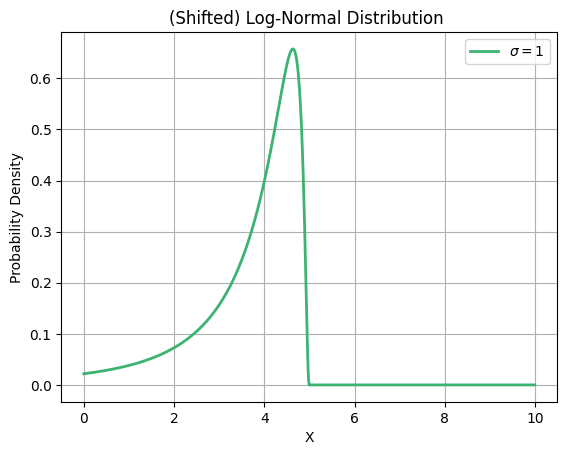

In [8]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
sigma_0 = 1
shift = 5 # Shift 

x_axis = np.arange(0, 10, 0.01)

pdf_x_mu0 = shift_log_normal_pdf(-x_axis, -shift, mu_0, sigma_0)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen', label='$\sigma=1$')
#plt.text(6, 0.42, '$\sigma=1$', color='mediumseagreen')
#plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue', label='$\sigma=0.25$')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [9]:
n_features = 7

np.random.seed(27)
x0 = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

In [10]:
# Gradient of the function
grad_loglike = grad(neg_loglike)

# Initial guess

# Use scipy's minimize function with the BFGS algorithm
result = minimize(neg_loglike, x0, method = 'BFGS')

result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: NaN result encountered.
  success: False
   status: 3
      fun: inf
        x: [ 1.286e+00 -3.036e-01  6.191e-01  3.960e-01  2.234e-01
            -5.434e-02 -1.793e-01  2.428e-01  0.000e+00  2.500e-01]
      nit: 0
      jac: [       nan        nan        nan        nan        nan
                   nan        nan        nan        nan        nan]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 11
     njev: 1

In [11]:
# derivates of neg_loglike
jacobian_  = jacobian(neg_loglike)

result = minimize(neg_loglike, x0, method = 'BFGS', \
               options={'disp': False}, jac = jacobian_)

result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: inf
        x: [ 1.286e+00 -3.036e-01  6.191e-01  3.960e-01  2.234e-01
            -5.434e-02 -1.793e-01  2.428e-01  0.000e+00  2.500e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 1
     njev: 1

In [12]:
# Extract the MAP from the parameter samples
MAP_params = result.x

MAP_intercept = MAP_params[0]
MAP_beta = MAP_params[1:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates \n--------------\n--------------")
print(f'Intercept:{MAP_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MAP_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates 
--------------
--------------
Intercept:1.2856054152322811
--------------
Regression coefficients
--------------
over_65_pc:-0.30355337730615073
female_pc:0.6190756618694475
ALevel_plus_pc:0.39599854914377247
white_pc:0.22340564775539556
HYP_afflicted_pc:-0.05433941722861124
DM_afflicted_pc:-0.17927632611276223
STIA_afflicted_pc:0.24283197254142283
--------------
Log normal coefficients
--------------
Mu: 0.0
Sigma: 0.25


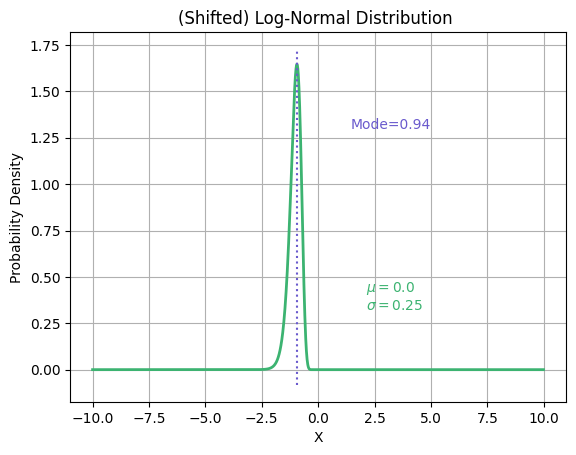

In [13]:
# mode of the log normal 
mode = log_norm_mode(MAP_mu, MAP_sigma)

# plot log normal of MAp parameters 
x_axis = np.arange(-10, 10, 0.01)
pdf_x_mu0 = shift_log_normal_pdf(-x_axis, 0, MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(2.1, 0.32, f'$\sigma=${MAP_sigma}', color='mediumseagreen')
plt.text(2.1, 0.42, f'$\mu=${MAP_mu}', color='mediumseagreen')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

ymin, ymax = plt.ylim()
plt.vlines(-mode, ymin, ymax, color='slateblue', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, 3*ymax/4, f'Mode={np.round(mode,2)}', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [14]:
y_pred = np.dot(x, MAP_beta) + MAP_intercept
diagnosis_gap = y - y_pred.squeeze()

# update the dataframe 
df_dem_plus['diagnosis_gap']=diagnosis_gap

ValueError: Expected a 1D array, got an array with shape (309, 309)

In [ ]:
y_pred

array([-64.12353775, -74.24463666, -69.81662469, -67.47162206,
       -67.33837317, -66.21628844, -67.81214722, -68.5225166 ,
       -69.96827159, -64.87112992, -65.01525932, -62.89739285,
       -63.23036623, -67.4935613 , -62.1679126 , -69.6192877 ,
       -66.86362668, -71.3835742 , -62.87950555, -71.11563867,
       -63.79081407, -64.21654   , -64.89064827, -69.03719081,
       -66.2687423 , -66.88945116, -63.85631964, -67.2037409 ,
       -62.44933332, -66.90084941, -68.0011281 , -63.37435341,
       -53.90719917, -67.13701684, -60.6528101 , -67.04885513,
       -68.98425308, -65.70051209, -67.10022744, -63.28110672,
       -69.55822515, -68.04892149, -66.64453051, -74.24891902,
       -66.59139084, -69.19471665, -67.82229875, -66.38588803,
       -65.28645624, -70.39757937, -63.38112976, -69.95879151,
       -68.78138604, -66.85908112, -70.84311549, -66.79873506,
       -64.96689105, -67.14279734, -60.92961836, -70.06333895,
       -70.5586653 , -60.69349186, -60.88972472, -63.48

In [ ]:
worst_5_resid = np.argsort(diagnosis_gap)[-5:]
df_dem_plus.iloc[worst_5_resid, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
183,Waverley,75.147021
83,Winchester,75.284729
101,Oxford,75.822470
293,Elmbridge,76.340127
207,Cambridge,83.814121


In [ ]:
worst_5_resid = np.argsort(diagnosis_gap)[:5]
df_dem_plus.iloc[worst_5_resid, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
167,Westminster,51.972451
32,Camden,54.392500
169,Coventry,57.714955
283,City of London,58.018017
284,Newham,58.055726
